This notebook attempts Facebook AI's pre-trained TFRoBERTa embeddings with token identification, question-answer, classification and regression heads on the base model. All modelling was run on a Kaggle GPU.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import re
import pickle
import gc
import nltk
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from transformers import *
import tokenizers
import matplotlib.pyplot as plt
print('TF version',tf.__version__)

TF version 2.0.0


In [2]:
MAX_LEN = 72
data = pd.read_csv("./data/train.csv")
testdata = pd.read_csv("./data/test.csv")
data.dropna(how="any", inplace=True)
#Attempt reproducibility
tf.random.set_seed(1)
np.random.seed(1)

In [3]:
def slang_cleaner(word):
    regex = re.compile(r'(\w*)(\w)\2(\w*)')
    replace = r'\1\2\3'
    if word=="": return word
    if word=="<3": return "LOVE" #Independent emoticon disambiguation
    for i in range(len(word)):
        if word[i] in ["!",".","?",":",",","`","-","="]: 
            return slang_cleaner(word[:i])+word[i]+slang_cleaner(word[i+1:])
    if nltk.corpus.wordnet.synsets(word): return word
    clean = regex.sub(replace, word)
    if (word==clean): return word
    else: return slang_cleaner(clean)
def cleaner(sent):
    #Two tokens (WEBSITE, VULGAR) are created and punctuation is spaced out
    sent = " ".join(np.vectorize(lambda s:"WEBSITE" if "http" in s or ("www" in s and "com" in s) else s)
                    (np.array(sent.split())))
    for punc in ["\!","\.","\?","\:","\;","\,"]:
        sent = re.sub(re.compile('(?:'+punc+'){2,}'),punc[1],sent)
    sent = re.sub("[`]","\'",sent)
    sent = re.sub(re.compile('(?:\*){2,}'),"VULGAR",sent)
    return (" ".join(np.vectorize(slang_cleaner)(np.array(sent.split())))).lower()
for col in ['text','selected_text']:
    data[col] = data[col].apply(lambda s: cleaner(s))
data = data.loc[data.text.apply(lambda s: len(s))!=1]

In [5]:
def validitycheck(s):
    target = s.selected_text.split()
    source = s.text.split()
    for i in range(len(source)):
        if (source[i]==target[0]) and (source[i:i+len(target)]==target): return True
    return False
data = data.loc[data.apply(validitycheck, axis=1)].reset_index(drop=True)

In [4]:
PATH = './tf-roberta/'
tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab_file=PATH+'vocab-roberta-base.json', 
    merges_file=PATH+'merges-roberta-base.txt', 
    lowercase=True,
    add_prefix_space=True
)
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

<h2> N-Gram Level Subtext Model </h2>

We continue with the observations established in ATTEMPT 2 regarding the similarity between "text" and "selected_text" for neutral sentiments which makes it favorable to merely predict the entire text (at 0.92 accuracy). For positive and negative labels, we attempt classifier and regressor designs to predict subtexts, or predict Jaccardian similarity with subtexts. While these methods yield above-baseline results, superior performance was achieved with QA Approach below.

<b> STEP 1: Classifier </b>

In [6]:
def X(text):
    ngrams, text = [], text.split()
    for i in range(len(text)):
        for j in range(i, len(text)):
            ngrams.append(" ".join(text[i:j+1]))
    return np.array(ngrams)
def Y(ngrams, selected_text):
    return np.vectorize(lambda s: int(s==selected_text))(np.array(ngrams))

In [7]:
length = data.loc[data.sentiment=="positive", "text"].apply(lambda s: np.sum(np.arange(len(s.split())+1)))
trainX = np.zeros(length.sum(), dtype="<U150")
trainY = np.zeros(length.sum(), dtype=np.float64)
i=0
for index, content in data.loc[data.sentiment=="positive"].iterrows():
    ngrams = X(content.text)
    trainX[i:i+len(ngrams)] = ngrams
    trainY[i:i+len(ngrams)] =  Y(ngrams, content.selected_text)
    i+=len(ngrams)

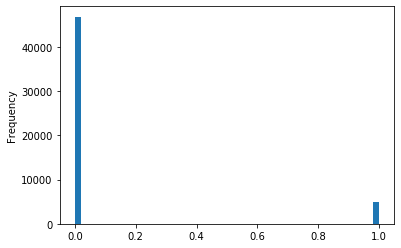

In [9]:
#Undersampling - Create a 5% Sampling Ratio
majority, minority = np.where(trainY==0)[0], np.where(trainY==1)[0]
kp = np.random.choice(majority, int(0.05*len(majority)), replace=False)
trainX = trainX[np.sort(np.append(minority, kp))]
trainY = trainY[np.sort(np.append(minority, kp))]
pd.Series(trainY).plot(kind="hist", bins=50)
plt.show()

In [10]:
#Positive Labels
MAX_LEN = 100
input_ids = np.ones((len(trainX),MAX_LEN),dtype='int32')
attention_mask = np.zeros((len(trainX),MAX_LEN),dtype='int32')
token_type_ids = np.zeros((len(trainX),MAX_LEN),dtype='int32')

for k in range(len(trainX)):
    text1 = " "+" ".join(trainX[k].split())
    enc = tokenizer.encode(text1)
    s_tok = sentiment_id["positive"]
    input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc.ids)+5] = 1

In [12]:
#Word-Level BERT LSTM ANN
def dense_mdl(nunits=100, recdrp=0.05, l2reg=0.05, drp=0.05):
    input_ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
    x1 = tf.keras.layers.LSTM(nunits, recdrp=recdrp, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                              bias_regularizer=tf.keras.regularizers.l2(l2reg), return_sequences=False)(x[0])
    x1 = tf.keras.layers.Dropout(drp)(x1)
    final = tf.keras.layers.Dense(1, activation="sigmoid")(x1)
    model = tf.keras.models.Model([input_ids, attention_mask, token_type_ids], final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5), loss="binary_crossentropy")
    return model

In [ ]:
mdl = dense_mdl()
mdl.fit([input_ids, attention_mask, token_type_ids], trainY, epochs=10, batch_size=50, verbose=True,
       class_weight={0:1, 1:pd.Series(trainY).value_counts()[0]/pd.Series(trainY).value_counts()[1]})

<b>STEP 2: Regressor </b>

In [ ]:
def Y(ngrams, subset):
    def jaccard(str1, str2):
        a, b = set(str1.lower().split()), set(str2.lower().split())
        c = a.intersection(b)
        return float(len(c)) / (len(a) + len(b) - len(c))
    return np.vectorize(lambda s: jaccard(s, subset))(np.array(ngrams))

In [ ]:
#Sentence-Level BERT Dense ANN with Dual Input
def dense_mdl(nunits=100, activation="relu", l2reg=0.05, drp=0.05):
    config = RobertaConfig.from_pretrained(PATH+'config-roberta-base.json')
    #Phrase analysis
    input_ids1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids1 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    bert_model1 = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x1 = bert_model(input_ids1, attention_mask=attention_mask1, token_type_ids=token_type_ids1)
    #Sentence analysis
    input_ids2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    attention_mask2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    token_type_ids2 = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    bert_model2 = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x2 = bert_model2(input_ids2, attention_mask=attention_mask2, token_type_ids=token_type_ids2)
    #Combined analysis
    x = tf.concat([x1[1],x2[1]], axis=-1)
    x = tf.keras.layers.Dense(nunits, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg))(x)
    x = tf.keras.layers.Dropout(drp)(x)
    final = tf.keras.layers.Dense(1, activation="sigmoid")(x)
    model = tf.keras.models.Model([input_ids1, attention_mask1, token_type_ids1, input_ids2, 
                                   attention_mask2,token_type_ids2], final)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4), loss="mean_squared_error")
    return model

<h2> HuggingFace Models </h2>

This model is inspired by Prof. Chris Deotte's question-answer head and labelling approach with HuggingFace. More details on the Kaggle discussion forum. The code below achieved a 0.697 Jaccard on the public leaderboard.

<b> STEP 1: Model Training

In [ ]:
def generate_labelling(info, training=True):
    input_ids = np.ones((info.shape[0],MAX_LEN),dtype='int32')
    attention_mask = np.zeros((info.shape[0],MAX_LEN),dtype='int32')
    token_type_ids = np.zeros((info.shape[0],MAX_LEN),dtype='int32')
    start_tokens = np.zeros((info.shape[0],MAX_LEN),dtype='int32')
    end_tokens = np.zeros((info.shape[0],MAX_LEN),dtype='int32')
    for k in range(info.shape[0]):
        text1 = " "+" ".join(info.loc[k,'text'].split())
        enc = tokenizer.encode(text1) 
        offsets = []; idx=0
        for t in enc.ids:
            w = tokenizer.decode([t])
            offsets.append((idx,idx+len(w)))
            idx += len(w)
        s_tok = sentiment_id[info.loc[k,'sentiment']]
        input_ids[k,:len(enc.ids)+5] = [0] + enc.ids + [2,2] + [s_tok] + [2]
        attention_mask[k,:len(enc.ids)+5] = 1
        if training:
            text2 = " ".join(info.loc[k,'selected_text'].split())
            idx = text1.find(text2)
            chars = np.zeros((len(text1)))
            chars[idx:idx+len(text2)]=1
            if text1[idx-1]==' ': chars[idx-1] = 1
            toks = []
            for i,(a,b) in enumerate(offsets):
                sm = np.sum(chars[a:b])
                if sm>0: toks.append(i)
            if len(toks)>0:
                start_tokens[k,toks[0]+1] = 1
                end_tokens[k,toks[-1]+1] = 1
    return input_ids, attention_mask, token_type_ids, start_tokens, end_tokens

In [ ]:
#Custom Loss Functions and Model Heads Attempted
def distance_weighted_categorical_crossentropy(y_true, y_pred):
    crossentropy = tf.reduce_sum(tf.math.multiply(tf.math.log(y_pred), tf.cast(y_true, dtype=tf.float32)), axis=-1)
    distance = tf.abs(tf.math.argmax(y_true, axis=-1)-tf.argmax(y_pred, axis=-1))+1
    return -tf.reduce_sum(tf.math.multiply(tf.math.sqrt(tf.cast(distance, dtype=tf.float32)), crossentropy))

#Small Addendum to leverage Token Classification for Individual Sentences
#bert_model = TFRobertaForTokenClassification.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
#x = bert_model(ids,attention_mask=att,token_type_ids=tok, training=training)
#x1 = tf.keras.layers.Flatten()(x[0][:,:,-1])
#x1 = tf.keras.layers.Activation('softmax')(x1)

In [ ]:
#Start-Index and End-Index Dual TFRoberta Model
def build_model(drp=0.1, l2reg=0.00, activation=None, kinit="glorot_uniform"):
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    config = RobertaConfig.from_pretrained(PATH+"config-roberta-base.json")
    bert_model = TFRobertaModel.from_pretrained(PATH+'pretrained-roberta-base.h5',config=config)
    x = bert_model(ids,attention_mask=att,token_type_ids=tok)
    x1 = tf.keras.layers.Dropout(drp)(x[0])
    x1 = tf.keras.layers.Conv1D(1,1, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg), kernel_initializer=kinit)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    x2 = tf.keras.layers.Dropout(drp)(x[0])
    x2 = tf.keras.layers.Conv1D(1,1, activation=activation, kernel_regularizer=tf.keras.regularizers.l2(l2reg),
                               bias_regularizer=tf.keras.regularizers.l2(l2reg), kernel_initializer=kinit)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model

In [ ]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
#Positive Label Training
train = data.loc[data.sentiment=="positive"].reset_index(drop=True)
input_ids, attention_mask, token_type_ids, start_tokens, end_tokens = generate_labelling(train, True)
tf.keras.backend.clear_session()
model = build_model()
model.fit([input_ids, attention_mask, token_type_ids], [start_tokens, end_tokens], 
        epochs=3, batch_size=64, verbose=True)
model.save_weights("posroberta.h5")

In [ ]:
#Negative Label Training
train = data.loc[data.sentiment=="negative"].reset_index(drop=True)
input_ids, attention_mask, token_type_ids, start_tokens, end_tokens = generate_labelling(train, True)
tf.keras.backend.clear_session()
model = build_model()
model.fit([input_ids, attention_mask, token_type_ids], [start_tokens, end_tokens], 
        epochs=3, batch_size=64, verbose=True)
model.save_weights("negroberta.h5")

<b> STEP 2: Model Predictions </b>

In [ ]:
#Neutral Labels
testdata = pd.read_csv("../input/tweet-sentiment-extraction/test.csv")
testdata['original_text'] = testdata['text'].copy()
testdata['text'] = testdata['text'].apply(lambda s: cleaner(s))
testdata['selected_text'] = np.nan
testdata.loc[testdata.sentiment=="neutral", "selected_text"] = testdata.loc[
    testdata.sentiment=="neutral", "original_text"]

In [ ]:
#SubText Generation Function
def subtext(info, input_ids, attention_mask, token_type_ids, model):
    begin, end = model.predict([input_ids, attention_mask, token_type_ids])
    for k in range(len(info)):
        text1 = " "+" ".join(info.loc[info.index[k],'text'].split())
        enc, st = tokenizer.encode(text1), None
        a = np.argmax(begin[k,])
        b = np.argmax(end[k,])
        if a>b:
            if np.max(end[k,])>np.max(begin[k,]):
                st = tokenizer.decode(enc.ids[:b])
            else:
                st = tokenizer.decode(enc.ids[a-1:])
        else:
            st = tokenizer.decode(enc.ids[a-1:b]) 
        info.loc[info.index[k], "selected_text"] = st

In [ ]:
#Positive Labels
postestdata = testdata.loc[testdata.sentiment=="positive"].reset_index(drop=True)
input_ids, attention_mask, token_type_ids, _, _ = generate_labelling(postestdata, False)
tf.keras.backend.clear_session()
model = build_model()
model.load_weights("posroberta.h5")
subtext(postestdata, input_ids, attention_mask, token_type_ids, model)

In [ ]:
#Negative Labels
negtestdata = testdata.loc[testdata.sentiment=="negative"].reset_index(drop=True)
input_ids, attention_mask, token_type_ids, _, _ = generate_labelling(negtestdata, False)
tf.keras.backend.clear_session()
model = build_model()
model.load_weights("negroberta.h5")
subtext(negtestdata, input_ids, attention_mask, token_type_ids, model)

In [ ]:
#Coherence Corrections
def startcorrect(fulltext, subtext):
    subtext = " ".join(subtext.split())
    i = fulltext.find(subtext)
    k = i
    while (k!=0) and (fulltext[k]!=" "): k-=1
    return fulltext[k:i]+subtext
def endcorrect(fulltext, subtext):
    subtext = " ".join(subtext.split())
    i = fulltext.find(subtext)+len(subtext)
    k = i
    while (k!=len(fulltext)) and (fulltext[k]!=" "): k+=1
    return subtext+fulltext[i:k]
def reverseprocessing(posttext, pretext, subtext):
    posttext = posttext.split()
    subtext = subtext.split()
    for i in range(len(posttext)):
        if (posttext[i:i+len(subtext)]==subtext):
            return " ".join(pretext.split()[i:i+len(subtext)])
    return np.nan

In [ ]:
#Consolidation
postestdata['selected_text']=postestdata.apply(
    lambda s: endcorrect(s.text, startcorrect(s.text, s.selected_text)), axis=1)
negtestdata['selected_text']=negtestdata.apply(
    lambda s: endcorrect(s.text, startcorrect(s.text, s.selected_text)), axis=1)
postestdata['selected_text']=postestdata.apply(
    lambda s: reverseprocessing(s.text, s.original_text, s.selected_text), axis=1)
negtestdata['selected_text']=negtestdata.apply(
    lambda s: reverseprocessing(s.text, s.original_text, s.selected_text), axis=1)
testdata = testdata.merge(postestdata[['textID','selected_text']], on="textID", how="left").merge(
    negtestdata[['textID', 'selected_text']], on="textID", how="left")
testdata['selected_text'] = testdata.apply(lambda s: pd.Series([s.selected_text_x, s.selected_text_y, 
                                                                s.selected_text]).dropna().values[0], axis=1)
testdata.drop(columns=["selected_text_x", "selected_text_y"], inplace=True)

In [ ]:
testdata[["textID","selected_text"]].to_csv("submission.csv", index=False)